In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from networkx.readwrite import json_graph

import os, json

# positive graph
with open("data/cisplatin_pos_kg.json") as f:
    data = json.load(f)

GP: nx.MultiDiGraph = json_graph.node_link_graph(data, edges="edges")
print(GP)

# negative graph
with open("data/cisplatin_neg45k_kg.json") as f:
    data = json.load(f)

GN: nx.MultiDiGraph = json_graph.node_link_graph(data, edges="edges")
print(GN)

MultiDiGraph with 6172 nodes and 848782 edges
MultiDiGraph with 7141 nodes and 4197345 edges


Unique positive features: [158, 438, 581, 737, 888, 903, 956, 1302, 1376, 2165, 2351, 2623, 3116, 3262, 3278, 3677, 4291, 4375, 4396, 5209, 5247, 5275, 5560, 5644, 5687, 5728, 6134, 6142, 6813, 7213, 7321, 8529, 8605, 8840, 9419, 9674, 9704, 9809, 9831, 10170]
Unique negative features: [5, 13, 26, 32, 44, 50, 51, 56, 59, 83, 84, 86, 87, 126, 133, 146, 6542, 155, 177, 180, 204, 211, 226, 243, 278, 281, 302, 325, 332, 335, 360, 364, 374, 394, 395, 402, 412, 446, 450, 477, 499, 507, 514, 523, 537, 550, 553, 560, 577, 591, 602, 604, 620, 623, 642, 656, 675, 687, 714, 728, 736, 740, 741, 744, 751, 755, 768, 769, 770, 785, 793, 802, 820, 837, 843, 846, 848, 849, 884, 906, 913, 914, 917, 919, 921, 939, 945, 946, 951, 958, 959, 978, 984, 990, 992, 1050, 1051, 1070, 1076, 1089, 1102, 1115, 1118, 1126, 1141, 1145, 1178, 1186, 1201, 1219, 1224, 1232, 1244, 1246, 1255, 1260, 1283, 1291, 1305, 1311, 1314, 1320, 1328, 1329, 1331, 1333, 1353, 1354, 1355, 1360, 1368, 1369, 1383, 1390, 1404, 1416, 1414

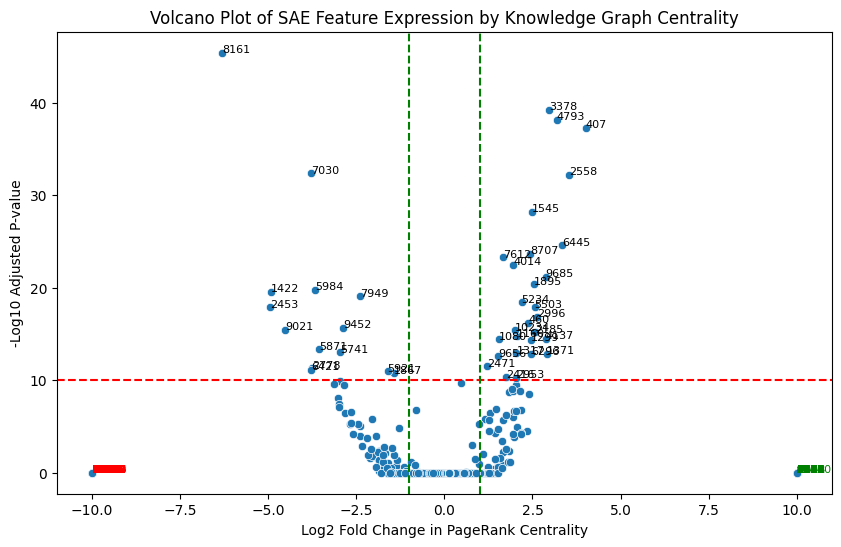

In [2]:
# calculate PR centrality
pos_cent_nodes = nx.pagerank(GP)
neg_cent_nodes = nx.pagerank(GN)

# calculate difference in centrality
cent_diff = {x: 0 for x in set(GP.nodes()).union(set(GN.nodes()))}
for node in cent_diff.keys():
    pos_value = pos_cent_nodes.get(node, 0)
    neg_value = neg_cent_nodes.get(node, 0)

    calc_p = True

    # calculate log2 fold change
    if neg_value == 0:
        cent_diff[node] = 10
        calc_p = False
    elif pos_value/neg_value == 0:
        cent_diff[node] = -10
        calc_p = False
    else:
        cent_diff[node] = np.log2(pos_value / neg_value)
    # calculate pairwise t-test p-value (some degree of variance is assumed)
    if calc_p:
        p = stats.ttest_ind_from_stats(mean1=pos_value, std1=0.0001, nobs1=10,
                                       mean2=neg_value, std2=0.0001, nobs2=10,
                                       equal_var=True).pvalue
        cent_diff[node] = (cent_diff[node], p)
    else:
        cent_diff[node] = (cent_diff[node], 1)
# apply bonferroni correction
num_tests = len(cent_diff) * 10 # account for re-sampling / variance assumption in p-value calculation
for node in cent_diff.keys():
    log2fc, p = cent_diff[node]
    adj_p = min(p * num_tests, 1.0)
    cent_diff[node] = (log2fc, adj_p)


# use seaborn to make a volcano plot of the centrality differences
log2fc_values = [v[0] for v in cent_diff.values()]
p_values = [v[1] for v in cent_diff.values()]
neg_log10_p_values = [-np.log10(p) if p > 0 else 0 for p in p_values]

adj_p_threshold = 1e-10
plt.figure(figsize=(10, 6))
sns.scatterplot(x=log2fc_values, y=neg_log10_p_values)
plt.title("Volcano Plot of SAE Feature Expression by Knowledge Graph Centrality")
plt.xlabel("Log2 Fold Change in PageRank Centrality")
plt.ylabel("-Log10 Adjusted P-value")
plt.axhline(y=-np.log10(adj_p_threshold), color='r', linestyle='--')
plt.axvline(x=1, color='g', linestyle='--')
plt.axvline(x=-1, color='g', linestyle='--')
# add labels for significant points and outliers
unique_pos = []
unique_neg = []
for node, (log2fc, adj_p) in cent_diff.items():
    if adj_p < adj_p_threshold and abs(log2fc) > 1:
        plt.text(log2fc, -np.log10(adj_p), node, fontsize=8)
    # highlight unique features
    if log2fc == 10:
        plt.text(log2fc, -np.log10(adj_p), node, fontsize=8, color='green')
        unique_pos.append(node)
    elif log2fc == -10:
        plt.text(log2fc, -np.log10(adj_p), node, fontsize=8, color='red')
        unique_neg.append(node)

print("Unique positive features:", unique_pos)
print("Unique negative features:", unique_neg)

plt.show()

MultiDiGraph with 5546 nodes and 218218 edges
Unique positive features: [1302, 1376, 3278, 6469, 7137, 9704]
Unique negative features: [2, 5, 13, 15, 26, 32, 44, 50, 51, 56, 59, 70, 83, 84, 86, 87, 95, 98, 101, 103, 126, 133, 146, 147, 6543, 155, 167, 177, 180, 188, 204, 211, 226, 231, 242, 243, 247, 249, 254, 261, 262, 265, 266, 273, 278, 281, 297, 299, 302, 301, 315, 325, 330, 332, 334, 335, 338, 352, 355, 360, 364, 368, 373, 374, 382, 394, 395, 401, 402, 412, 428, 443, 446, 450, 459, 474, 479, 482, 477, 484, 491, 499, 502, 505, 507, 514, 516, 523, 537, 545, 550, 553, 554, 556, 559, 560, 562, 577, 591, 598, 600, 602, 604, 613, 620, 623, 633, 642, 643, 652, 655, 656, 659, 665, 675, 687, 714, 728, 736, 740, 741, 744, 746, 751, 755, 756, 768, 769, 770, 785, 793, 802, 804, 820, 828, 834, 837, 846, 848, 849, 858, 872, 884, 906, 913, 914, 917, 919, 921, 928, 939, 945, 946, 950, 951, 958, 959, 978, 984, 990, 992, 1006, 1030, 1034, 1041, 1050, 1051, 1070, 1076, 1085, 1086, 1089, 1108, 1115, 

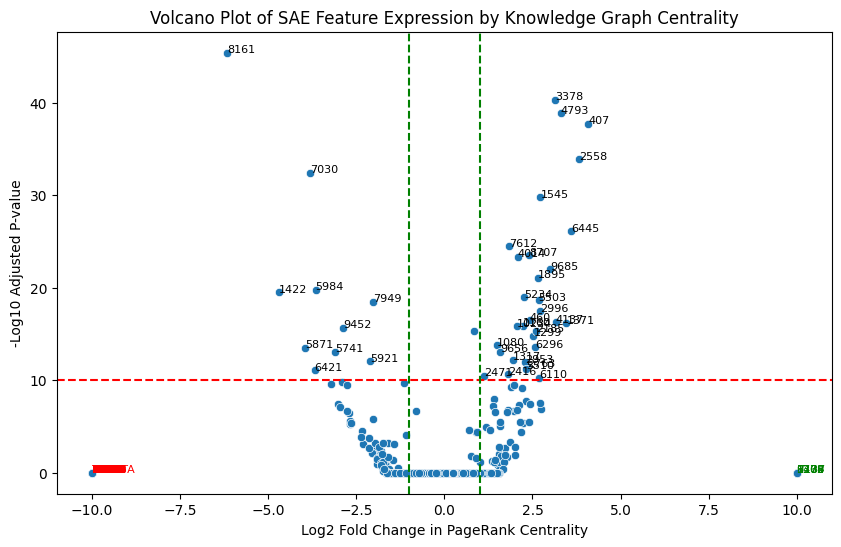

In [3]:
# with refined cisplatin binding KG data from Nair and Richi
with open("data/refined_cisplt_bind.json") as f:
    data = json.load(f)

GP: nx.MultiDiGraph = json_graph.node_link_graph(data, edges="edges")
print(GP)

# calculate PR centrality
pos_cent_nodes = nx.pagerank(GP)
neg_cent_nodes = nx.pagerank(GN)

# calculate difference in centrality
cent_diff = {x: 0 for x in set(GP.nodes()).union(set(GN.nodes()))}
for node in cent_diff.keys():
    pos_value = pos_cent_nodes.get(node, 0)
    neg_value = neg_cent_nodes.get(node, 0)

    calc_p = True

    # calculate log2 fold change
    if neg_value == 0:
        cent_diff[node] = 10
        calc_p = False
    elif pos_value/neg_value == 0:
        cent_diff[node] = -10
        calc_p = False
    else:
        cent_diff[node] = np.log2(pos_value / neg_value)
    # calculate pairwise t-test p-value (some degree of variance is assumed)
    if calc_p:
        p = stats.ttest_ind_from_stats(mean1=pos_value, std1=0.0001, nobs1=10,
                                       mean2=neg_value, std2=0.0001, nobs2=10,
                                       equal_var=True).pvalue
        cent_diff[node] = (cent_diff[node], p)
    else:
        cent_diff[node] = (cent_diff[node], 1)

# apply bonferroni correction
num_tests = len(cent_diff) * 10 # account for re-sampling / variance assumption in p-value calculation
for node in cent_diff.keys():
    log2fc, p = cent_diff[node]
    adj_p = min(p * num_tests, 1.0)
    cent_diff[node] = (log2fc, adj_p)


# use seaborn to make a volcano plot of the centrality differences
log2fc_values = [v[0] for v in cent_diff.values()]
p_values = [v[1] for v in cent_diff.values()]
neg_log10_p_values = [-np.log10(p) if p > 0 else 0 for p in p_values]

adj_p_threshold = 1e-10
plt.figure(figsize=(10, 6))
sns.scatterplot(x=log2fc_values, y=neg_log10_p_values)
plt.title("Volcano Plot of SAE Feature Expression by Knowledge Graph Centrality")
plt.xlabel("Log2 Fold Change in PageRank Centrality")
plt.ylabel("-Log10 Adjusted P-value")
plt.axhline(y=-np.log10(adj_p_threshold), color='r', linestyle='--')
plt.axvline(x=1, color='g', linestyle='--')
plt.axvline(x=-1, color='g', linestyle='--')
# add labels for significant points and outliers
unique_pos = []
unique_neg = []
for node, (log2fc, adj_p) in cent_diff.items():
    if adj_p < adj_p_threshold and abs(log2fc) > 1:
        plt.text(log2fc, -np.log10(adj_p), node, fontsize=8)
    # highlight unique features
    if log2fc == 10:
        plt.text(log2fc, -np.log10(adj_p), node, fontsize=8, color='green')
        unique_pos.append(node)
    elif log2fc == -10:
        plt.text(log2fc, -np.log10(adj_p), node, fontsize=8, color='red')
        unique_neg.append(node)

print("Unique positive features:", unique_pos)
print("Unique negative features:", unique_neg)

plt.show()